In [ ]:
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

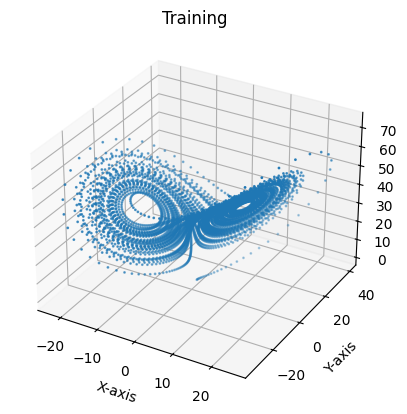

Training data shape: (5001, 3)


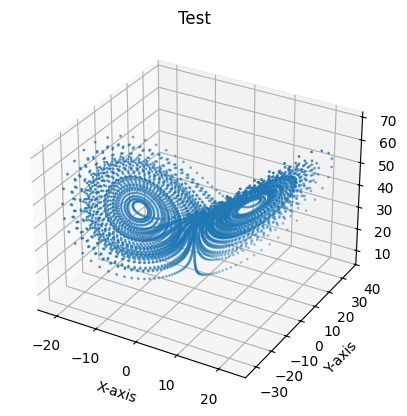

Validation data shape: (5000, 3)


In [80]:
data_filename = Path('../data/lorenz_training.npy')
if not data_filename.exists():
    raise FileNotFoundError(f"Data file {data_filename} not found.")

lorenz_data_training = np.load(data_filename)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lorenz_data_training[:, 0], lorenz_data_training[:, 1], lorenz_data_training[:, 2], s=1)
plt.title('Training')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

print(f"Training data shape: {lorenz_data_training.shape}")


data_filename = Path('../data/lorenz_truth.npy')
if not data_filename.exists():
    raise FileNotFoundError(f"Data file {data_filename} not found.")

lorenz_data_validation = np.load(data_filename)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lorenz_data_validation[:, 0], lorenz_data_validation[:, 1], lorenz_data_validation[:, 2], s=1)
plt.title('Test')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

print(f"Validation data shape: {lorenz_data_validation.shape}")

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim=3, output_dim=3, hidden_dim=64):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class SmoothReLU(nn.Module):
    def __init__(self, d=1):
        super().__init__()
        self.a = 1 / (2 * d)
        self.b = d / 2

    def forward(self, x):
        return torch.max(
            torch.clamp(torch.sign(x) * self.a * x**2, min=0, max=self.b), x - self.b
        )
        
class InputConvexNN(nn.Module):
    def __init__(
        self, input_dim, hidden_dim, n_hidden, activation=SmoothReLU(), output_dim=1
    ):
        super().__init__()
        self.n_hidden = n_hidden
        self.activation = activation
        self.linear = nn.ModuleList(
            [nn.Linear(input_dim, hidden_dim)]
            + [nn.Linear(hidden_dim, hidden_dim) for _ in range(n_hidden)]
            + [nn.Linear(hidden_dim, output_dim)]
        )
        self.skip = nn.ModuleList(
            [nn.Linear(input_dim, hidden_dim) for _ in range(n_hidden)]
            + [nn.Linear(input_dim, output_dim)]
        )

    def forward(self, x):
        z = self.activation(self.linear[0](x))
        for i in range(self.n_hidden + 1):
            z = self.activation(self.linear[i + 1](z) + self.skip[i](x))
        return z


class PSDWrapper(nn.Module):
    def __init__(self, f, epsilon=1e-3, activation=torch.relu):
        super().__init__()
        self.epsilon = epsilon
        self.activation = activation
        self.f = f

    def forward(self, x):
        return self.activation(
            self.f(x) - self.f(torch.zeros_like(x))
        ) + self.epsilon * torch.linalg.vector_norm(x, dim=1, keepdim=True)


class LyapunovProjectedDynamics(nn.Module):
    def __init__(self, f_hat, V, beta=0.99):
        super().__init__()
        self.f_hat = f_hat
        self.V = V
        self.beta = beta

    def forward(self, x):
        V = self.V(x)
        x_next = self.f_hat(x)
        V_target = self.beta * V
        V_next = self.V(x_next)

        return x_next * ((V_target - torch.relu(V_target - V_next)) / V_next)

In [95]:
state_dim = lorenz_data_training.shape[1]

# Initialize the models
f_hat = MLP(input_dim=state_dim, output_dim=state_dim, hidden_dim=128)
V = PSDWrapper(
    InputConvexNN(
        input_dim=state_dim,
        hidden_dim=128,
        n_hidden=3,
        activation=SmoothReLU(),
        output_dim=1,
    ),
    epsilon=1e-6,
    activation=torch.relu,
)
f = LyapunovProjectedDynamics(f_hat, V, beta=0.99)

In [96]:
class LorenzDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)-1

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.data[(idx + 1)]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

training_dataset = LorenzDataset(lorenz_data_training)
validation_dataset = LorenzDataset(lorenz_data_validation)
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)

In [97]:
from tqdm import trange

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(f.parameters(), lr=1e-5)
num_epochs = 100
num_epochs_validation = 50
batch_size = 32

# Training loop
pbar = trange(num_epochs, desc="Training", unit="epoch")
for epoch in pbar:
    f.train()
    running_loss = 0.0
    for i, (x, y) in enumerate(training_dataloader):
        optimizer.zero_grad()
        y_pred = f(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()    

    pbar.set_postfix(loss=running_loss / len(training_dataloader))
    
    # Validation loop
    if epoch % num_epochs_validation == 0:
        f.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for i, (x, y) in enumerate(validation_dataloader):
                y_pred = f(x)
                loss = loss_fn(y_pred, y)
                validation_loss += loss.item()
        print(f"Validation loss: {validation_loss / len(validation_dataloader)}")


Training:   1%|          | 1/100 [00:04<06:54,  4.19s/epoch, loss=490]

Validation loss: 442.6796944976612


Training:  51%|█████     | 51/100 [01:55<01:59,  2.44s/epoch, loss=0.66] 

Validation loss: 0.6533461569031332


Training: 100%|██████████| 100/100 [03:39<00:00,  2.20s/epoch, loss=0.525]


In [98]:
n_rollout = 5000
x0 = lorenz_data_validation[0]
trajectory = torch.empty(n_rollout, x0.shape[0])
x = torch.tensor(x0, dtype=torch.float32).reshape(1, -1)
for i in range(n_rollout):
    x = f(x)
    trajectory[i, :] = x.squeeze()
trajectory = trajectory.detach().numpy()

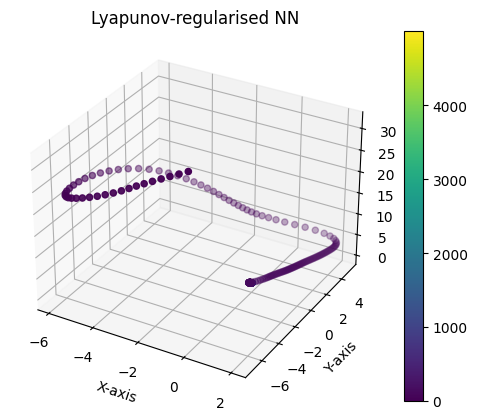

In [101]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], c=np.arange(n_rollout), cmap='viridis', marker='o')
plt.colorbar(p)
plt.title('Lyapunov-regularised NN')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [102]:
def scoring_lorenz(truth, prediction, k=20, modes=100):
    '''produce long-time and short-time error scores.'''
    [m,n]=truth.shape
    Est = np.linalg.norm(truth[:,0:k]-prediction[:,0:k],2)/np.linalg.norm(truth[:,0:k],2)

    yt = truth[-modes:, :]
    M = np.arange(-30, 31, 1)
    M2 = np.arange(0, 71, 1)
    yhistxt, xhistx = np.histogram(yt[:, 0], bins=M)
    yhistyt, xhisty = np.histogram(yt[:, 1], bins=M)
    yhistzt, xhistz = np.histogram(yt[:, 2], bins=M2)

    yp = prediction[-modes:, :]
    yhistxp, xhistx = np.histogram(yp[:, 0], bins=M)
    yhistyp, xhisty = np.histogram(yp[:, 1], bins=M)
    yhistzp, xhistz = np.histogram(yp[:, 2], bins=M2)
    
    Eltx = np.linalg.norm(yhistxt-yhistxp,2)/np.linalg.norm(yhistxt,2)
    Elty = np.linalg.norm(yhistyt-yhistyp,2)/np.linalg.norm(yhistyt,2)
    Eltz = np.linalg.norm(yhistzt-yhistzp,2)/np.linalg.norm(yhistzt,2)
    
    Elt =  (Eltx+Elty+Eltz)/3
    
    E1 = 100*(1-Est)
    E2 = 100*(1-Elt)

    if np.isnan(E1):
        E1 = -np.inf
    if np.isnan(E2):
        E2 = -np.inf
    
    return E1, E2

scores = scoring_lorenz(lorenz_data_validation, trajectory)
scores

(np.float64(0.4056344217104435), np.float64(-350.464195507361))